# 页首

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import QUANTAXIS as QA
import pandas as pd
import numpy as np
import talib

#设定绘图的默认大小
import matplotlib
matplotlib.rcParams["figure.figsize"]=[16,5]

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK SC','SimHei']
matplotlib.rcParams['axes.unicode_minus']=False #用来正常显示负号

import matplotlib.pyplot as plt

#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set(font=['Noto Sans CJK SC','SimHei'])

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from talib import MA_Type

Using TensorFlow backend.


In [2]:
from keras_helper import get_raw_data
from keras_helper import normalize
from keras_helper import buildData
from keras_helper import toNpArray

In [3]:
data_raw=get_raw_data()

# 方法定义

In [44]:
def buildManyToManyModel(shape):
    model = Sequential()
    #input_dim: 输入的维度（整数）。 将此层用作模型中的第一层时，此参数（或者，关键字参数 input_shape）是必需的。
    #input_length: 输入序列的长度，在恒定时指定。 
    #如果你要在上游连接 Flatten 和 Dense 层， 则需要此参数（如果没有它，无法计算全连接输出的尺寸）。 
    #请注意，如果循环神经网络层不是模型中的第一层， 则需要在第一层的层级指定输入长度（例如，通过 input_shape 参数）。
    model.add(LSTM(10, input_shape=(shape[1], shape[2])))
    # 
    model.add(Dense(5))
    # 模型编译
    # 在训练模型之前，您需要配置学习过程，这是通过 compile 方法完成的。它接收三个参数：

    # 优化器 optimizer。它可以是现有优化器的字符串标识符，如 rmsprop 或 adagrad，也可以是 Optimizer 类的实例。
    # 详见：optimizers。
    # 损失函数 loss，模型试图最小化的目标函数。它可以是现有损失函数的字符串标识符，
    # 如 categorical_crossentropy 或 mse，也可以是一个目标函数。详见：losses。
    # 评估标准 metrics。对于任何分类问题，你都希望将其设置为 metrics = ['accuracy']。
    # 评估标准可以是现有的标准的字符串标识符，也可以是自定义的评估标准函数。
#     metrics: 在训练和测试期间的模型评估标准。通常你会使用 metrics = ['accuracy']。 
#         要为多输出模型的不同输出指定不同的评估标准，还可以传递一个字典，如 metrics = {'output_a'：'accuracy'}。
    model.compile(loss="mse", optimizer="adam",metrics=['mae', 'acc'])
    model.summary()
    return model

def _plot_history(history):
    # 绘制训练 & 验证的准确率值
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # 绘制训练 & 验证的损失值
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def do(data,data_normalize=True,dropna=True,test_size=0.2,
       pastDays=30,futureDays=5,skipDays=0,
       model_func=buildManyToManyModel,verbose=1,epochs=1000,
       validation_split=0.2,callbacks=None,plot_history=True,
       print_score=True,print_data_count=-10,leave_data_count=100,predict_leave_data=True):
    """
    取 `pastDays` 的数据作为计算数据。计算 `futureDays` 的数据。跳过 `skipDays` 的数据。
    Args:
    leave_data_count: 保留数据量（data的最后 X 条数据。默认为100。经过 data_normalize 和 dropna处理）
    predict_leave_data: 是否对 leave_data_count 保留的数据做 predict 计算。
    """
    if dropna:
        data=data.dropna()
    if data_normalize:
        data=normalize(data)
    if print_data_count>=0:
        print(data.head(print_data_count))
    X,Y=buildData(data,pastDays=pastDays,futureDays=futureDays,skipDays=skipDays)
    X_leave=None
    Y_leave=None
    if leave_data_count>0:
        X_leave=X[-1*leave_data_count:]
        Y_leave=Y[-1*leave_data_count:]
        X=X[:-1*leave_data_count]
        Y=Y[:-1*leave_data_count]
    X_arr=toNpArray(X)
    Y_arr=toNpArray(Y)
    X_train, X_test, y_train, y_test = train_test_split(X_arr,Y_arr,test_size=test_size)
    model=model_func(X_train.shape)
    history=model.fit(X_train, y_train,epochs=epochs, verbose=verbose,validation_split=validation_split, callbacks=callbacks)
    score=model.evaluate(X_test,y_test)
    if print_score:
        for i in range(len(model.metrics_names)):
            print('{0}:{1}'.format(model.metrics_names[i],score[i]))
    if plot_history:
        _plot_history(history)
    predict_leave=None
    if leave_data_count>0 and predict_leave_data:
        predict_leave=model.predict(X_leave)
    return model,history,score,X,Y,X_train, X_test, y_train, y_test,X_leave,Y_leave,predict_leave

In [6]:
callbacks=[EarlyStopping(monitor="loss", patience=10, verbose=0, mode="auto")]

# 120天数据，计算未来5天

## BBands

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                1360      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
Total params: 1,415
Trainable params: 1,415
Non-trainable params: 0
_________________________________________________________________
559/559 [==============================] - 0s 844us/step
loss:0.00041561672452142484
mean_absolute_error:0.012968311706068051
acc:0.2057245081433883


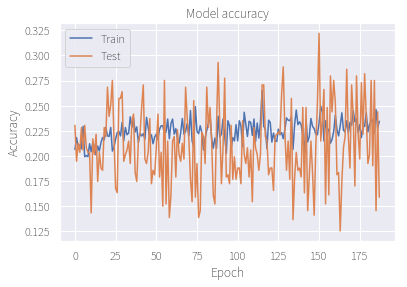

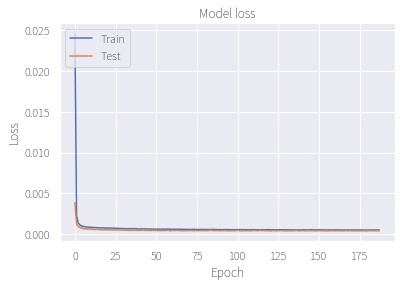

In [10]:
data=data_raw.drop(columns=['code','amount','preclose','adj'])

# 各种不同算法的移动均线，5日上下均为2倍标准差
data['bbands_EMA_5_2_2_up'],data['bbands_EMA_5_2_2_mid'],data['bbands_EMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.EMA)
data['bbands_DEMA_5_2_2_up'],data['bbands_DEMA_5_2_2_mid'],data['bbands_DEMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.DEMA)
data['bbands_T3_5_2_2_up'],data['bbands_T3_5_2_2_mid'],data['bbands_T3_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.T3)
data['bbands_TEMA_5_2_2_up'],data['bbands_TEMA_5_2_2_mid'],data['bbands_TEMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.TEMA)
data['bbands_TRIMA_5_2_2_up'],data['bbands_TRIMA_5_2_2_mid'],data['bbands_TRIMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.TRIMA)
data['bbands_WMA_5_2_2_up'],data['bbands_WMA_5_2_2_mid'],data['bbands_WMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.WMA)

model,history,score,X,Y,X_train, X_test, y_train, y_test,X_leave,Y_leave,predict_leave=do(data,callbacks=callbacks,verbose=0,pastDays=120)

## 量价指标/量能指标

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                800       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 55        
Total params: 855
Trainable params: 855
Non-trainable params: 0
_________________________________________________________________
559/559 [==============================] - 0s 875us/step
loss:0.0005019304404732453
mean_absolute_error:0.013938580944547713
acc:0.28264758523973454


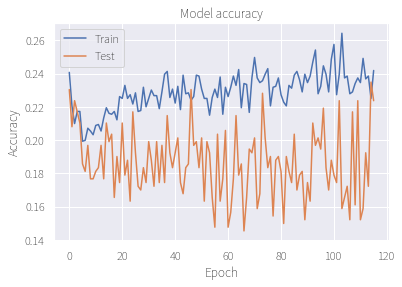

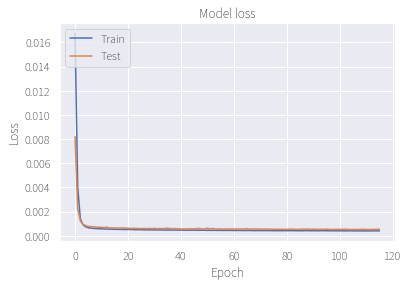

In [11]:
data=data_raw.drop(columns=['code','amount','preclose','adj'])
# 各种不同算法的移动均线，5日上下均为2倍标准差
data=data.join(QA.QA_indicator_OBV(data))
data=data.join(QA.QA_indicator_VR(data)[['VR']])
data=data.join(QA.QA_indicator_VRSI(data))
data=data.join(QA.QA_indicator_VSTD(data))
model,history,score,X,Y,X_train, X_test, y_train, y_test,X_leave,Y_leave,predict_leave=do(data,callbacks=callbacks,verbose=0,pastDays=120)

## 趋向指标/量价指标/量能指标

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10)                1080      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
Total params: 1,135
Trainable params: 1,135
Non-trainable params: 0
_________________________________________________________________
500/500 [==============================] - 0s 866us/step
loss:0.0003317090367199853
mean_absolute_error:0.012133886560797691
acc:0.25600000047683713


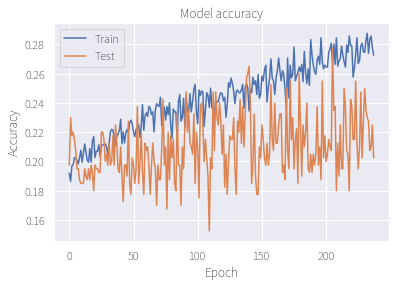

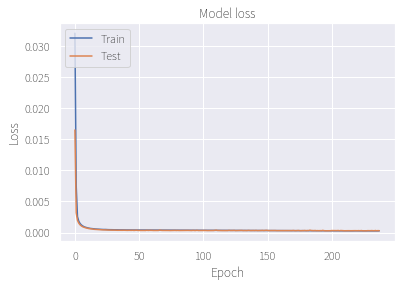

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 100 arrays: [array([[ 0.41068581,  0.40871237,  0.4021938 , ...,  0.11028811,
         0.20296897,  0.38975322],
       [ 0.39445765,  0.39788105,  0.38761607, ...,  0.05897364,
         0.19679162,  0.39265575],...

In [45]:
data=data_raw.drop(columns=['code','amount','preclose','adj'])
# 各种不同算法的移动均线，5日上下均为2倍标准差
data=data.join(QA.QA_indicator_OBV(data))
data=data.join(QA.QA_indicator_VR(data)[['VR']])
data=data.join(QA.QA_indicator_VRSI(data))
data=data.join(QA.QA_indicator_VSTD(data))
data=data.join(QA.QA_indicator_DMI(data))
data=data.join(QA.QA_indicator_MTM(data))
# data=data.join(QA.QA_indicator_CHO(data))
# data=data.join(QA.QA_indicator_EMA(data,5))
# data=data.join(QA.QA_indicator_EMA(data,30))
data=data.join(QA.QA_indicator_EMA(data,120))
model,history,score,X,Y,X_train, X_test, y_train, y_test,X_leave,Y_leave,predict_leave=do(data[:-100],callbacks=callbacks,verbose=0,pastDays=120)

In [42]:
model.predict(X_test)

array([[-0.10773186, -0.10505319, -0.10920399, -0.10470259, -0.10802126],
       [-0.07837313, -0.07841472, -0.08383411, -0.08302216, -0.08769783],
       [ 0.03253669,  0.03531465,  0.03585912,  0.03772268,  0.04108116],
       ...,
       [ 0.06389137,  0.06499749,  0.06186814,  0.06712763,  0.06463134],
       [ 0.13585761,  0.13553497,  0.13744317,  0.14145899,  0.13956802],
       [-0.15330036, -0.15140243, -0.15091614, -0.14572635, -0.14868782]],
      dtype=float32)

In [43]:
y_test

array([[-0.10168734, -0.08951209, -0.09357051, -0.0922177 , -0.10304014],
       [-0.07925879, -0.09209807, -0.07925879, -0.0629179 , -0.0629179 ],
       [ 0.03178338,  0.04474687,  0.03016295,  0.03340382,  0.02692208],
       ...,
       [ 0.05659576,  0.06124263,  0.07053638,  0.07363429,  0.05659576],
       [ 0.15130254,  0.15300975,  0.15130254,  0.1615458 ,  0.16325301],
       [-0.15445436, -0.15589406, -0.14725589, -0.15013528, -0.1429368 ]])

读取数据并对数据进行包装

In [13]:

# data=data_raw.drop(columns=['code','amount','preclose','adj'])

# # 各种不同算法的移动均线，5日上下均为2倍标准差
# data['bbands_EMA_5_2_2_up'],data['bbands_EMA_5_2_2_mid'],data['bbands_EMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.EMA)
# data['bbands_DEMA_5_2_2_up'],data['bbands_DEMA_5_2_2_mid'],data['bbands_DEMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.DEMA)
# data['bbands_T3_5_2_2_up'],data['bbands_T3_5_2_2_mid'],data['bbands_T3_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.T3)
# data['bbands_TEMA_5_2_2_up'],data['bbands_TEMA_5_2_2_mid'],data['bbands_TEMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.TEMA)
# data['bbands_TRIMA_5_2_2_up'],data['bbands_TRIMA_5_2_2_mid'],data['bbands_TRIMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.TRIMA)
# data['bbands_WMA_5_2_2_up'],data['bbands_WMA_5_2_2_mid'],data['bbands_WMA_5_2_2_down']=QA.BBANDS(data['close'],matype=MA_Type.WMA)
# data=data.dropna()
# data.head(1)

归一化

In [14]:
# data=normalize(data)
# data.head(1)

构建及拆分数据

In [15]:
# X,Y=buildData(data)
# X_arr=toNpArray(X)
# Y_arr=toNpArray(Y)
# X_train, X_test, y_train, y_test = train_test_split(X_arr,Y_arr,test_size=0.2)
# X_arr.shape, Y_arr.shape,X_train.shape, X_test.shape, y_train.shape, y_test.shape

https://keras.io/zh/layers/recurrent/#lstm
    
[Sequential 顺序模型指引](https://keras.io/zh/getting-started/sequential-model-guide/)

In [16]:
# model = buildManyToManyModel(X_train.shape)
# cb_loss = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
# # epochs: 整数。训练模型迭代轮次。一个轮次是在整个 x 或 y 上的一轮迭代。
# #     请注意，与 initial_epoch 一起，epochs 被理解为 「最终轮次」。
# #     模型并不是训练了 epochs 轮，而是到第 epochs 轮停止训练。
# # batch_size: 整数或 None。每次提度更新的样本数。如果未指定，默认为 32.
# # validation_split: 在 0 和 1 之间浮动。用作验证集的训练数据的比例。
# #     模型将分出一部分不会被训练的验证数据，并将在每一轮结束时评估这些验证数据的误差和任何其他模型指标。
# #     验证数据是混洗之前 x 和y 数据的最后一部分样本中。
# # shuffle: 布尔值（是否在每轮迭代之前混洗数据）或者 字符串 (batch)。
# #     batch 是处理 HDF5 数据限制的特殊选项，它对一个 batch 内部的数据进行混洗。
# #     当 steps_per_epoch 非 None 时，这个参数无效。
# # validation_data: 元组 (x_val，y_val) 或元组 (x_val，y_val，val_sample_weights)，用来评估损失，
# #     以及在每轮结束时的任何模型度量指标。模型将不会在这个数据上进行训练。
# #     这个参数会覆盖 validation_split。
# history=model.fit(X_train, y_train, epochs=1000, validation_split=0.2, callbacks=[cb_loss])

In [17]:
# score=model.evaluate(X_test,y_test)
# for i in range(len(model.metrics_names)):
#     print('{0}:{1}'.format(model.metrics_names[i],score[i]))

In [18]:
# # 绘制训练 & 验证的准确率值
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [19]:
# # 绘制训练 & 验证的损失值
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [20]:
# Y_pred=model.predict(X_test,verbose=1)

In [21]:
# def ttt(i):
#     if i>=len(Y_pred):
#         raise ValueError(i)
#     sns.lineplot(data=Y_pred[i],label='pred')
#     sns.lineplot(data=y_test[i],label='real')
#     df= pd.DataFrame([Y_pred[i],y_test[i]]).T
#     df['x']=df[0]/df[1]-1
#     return df

In [22]:
# ttt(200)

数据演示

In [23]:
# data = data_raw.drop(columns=['code','amount','preclose','adj'])
# # 包装数据
# data_Aug = augFeatures(data)
# # 归一化数据
# data_norm = normalize(data_Aug)
# # 构建结果集
# X,Y=buildData(data_norm)
# # 按顺序拆分数据和结果
# X_train, X_test, y_train, y_test = splitBuildData(X, Y,shuffle=False)

In [24]:
# #X_train集合中每一个元素（30天的数据）与X集合中每一个元素的对应关系（因为是按照顺序拆分的）
# X_train[0]
# np.array([np.array(x.values) for x in X])[0]

In [25]:
# #将原本的集合中包含DataFrame的X，或者集合中包含Series的Y，转换成np.array类型
# X_train=toNpArray(X_train)
# X_test=toNpArray(X_test)
# y_train=toNpArray(y_train)
# y_test=toNpArray(y_test)
# X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [26]:
# data = data_raw.drop(columns=['code','amount','preclose','adj'])
# data_Aug = augFeatures(data)
# data_norm = normalize(data_Aug)
# X,Y=buildData(data_norm[:-200])
# # X_train, X_test, y_train, y_test = splitBuildData(X, Y)

# # X_train=toNpArray(X_train)
# # X_test=toNpArray(X_test)
# # y_train=toNpArray(y_train)
# # y_test=toNpArray(y_test)

# X_np=toNpArray(X)
# Y_np=toNpArray(Y)

# model = buildManyToManyModel(X_train.shape)
# cb_loss = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
# # epochs: 整数。训练模型迭代轮次。一个轮次是在整个 x 或 y 上的一轮迭代。
# #     请注意，与 initial_epoch 一起，epochs 被理解为 「最终轮次」。
# #     模型并不是训练了 epochs 轮，而是到第 epochs 轮停止训练。
# # batch_size: 整数或 None。每次提度更新的样本数。如果未指定，默认为 32.
# # validation_split: 在 0 和 1 之间浮动。用作验证集的训练数据的比例。
# #     模型将分出一部分不会被训练的验证数据，并将在每一轮结束时评估这些验证数据的误差和任何其他模型指标。
# #     验证数据是混洗之前 x 和y 数据的最后一部分样本中。
# # shuffle: 布尔值（是否在每轮迭代之前混洗数据）或者 字符串 (batch)。
# #     batch 是处理 HDF5 数据限制的特殊选项，它对一个 batch 内部的数据进行混洗。
# #     当 steps_per_epoch 非 None 时，这个参数无效。
# # validation_data: 元组 (x_val，y_val) 或元组 (x_val，y_val，val_sample_weights)，用来评估损失，
# #     以及在每轮结束时的任何模型度量指标。模型将不会在这个数据上进行训练。
# #     这个参数会覆盖 validation_split。
# history=model.fit(X_np, Y_np, epochs=1000, batch_size=128, validation_split=0.15, callbacks=[cb_loss])

In [27]:
# X,Y=buildData(data_norm[-200:])

# X_np=toNpArray(X)
# Y_np=toNpArray(Y)

# # x: 输入数据，Numpy 数组（或者如果模型有多个输入，则为 Numpy 数组列表）。
# # batch_size: 整数。如未指定，默认为 32。
# # verbose: 日志显示模式，0 或 1。
# # steps: 声明预测结束之前的总步数（批次样本）。默认值 None。
# Y_pred=model.predict(X_np,verbose=1)

In [28]:
# Y_pred.shape

In [29]:
# Y_np.shape

In [30]:
# Y[0]

In [31]:
# Y_np[0]

In [32]:
# test=[]
# for i in range(len(Y_pred)):
#     df=pd.DataFrame(Y_pred[i],index=Y[i].index,columns=['预测值']).join(Y[i])
#     print(df)
#     test.append(df)

In [33]:
# ce_yc=[]
# ce_sj=[]
# for t in test:
#     ce=t.iloc[-1]-t.iloc[0]#差额
#     ce_yc.append(ce['预测值'])
#     ce_sj.append(ce['close'])
# sns.lineplot(x=range(len(ce_yc)),y=ce_yc,label='yc')
# sns.lineplot(x=range(len(ce_sj)),y=ce_sj,label='sj')

In [34]:
# sns.lineplot(data=test[0].append(test[5]))